In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as cp
import sys
sys.path.append("/datavon1/kqeq_fits_for_mace_comparison/waterEnergy/qpac")
from qpac.utils import addPeriodicity
# ase imports
import ase.io
from ase import Atoms, Atom
from ase import units
from ase.build import molecule
# for MD
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory
from ase.io import read,write

In [2]:
def rms_dict(x_ref, x_pred):
    """ Takes two datasets of the same shape and returns a dictionary containing RMS error data"""

    x_ref = np.array(x_ref)
    x_pred = np.array(x_pred)

    if np.shape(x_pred) != np.shape(x_ref):
        raise ValueError('WARNING: not matching shapes in rms')

    error_2 = (x_ref - x_pred) ** 2

    average = np.sqrt(np.average(error_2))
    std_ = np.sqrt(np.var(error_2))

    return {'rmse': average, 'std': std_}

In [3]:
def printenergy(a):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


In [4]:
train_set = read("trainWater.xyz@:10",format="extxyz")
test_set = read("testWater.xyz@:10",format="extxyz")
addPeriodicity(train_set)
addPeriodicity(test_set)

In [5]:
# mols = read("neutW6.xyz@:",format='extxyz')
# train_set = mols[:5]
# test_set = mols[1:2]
# addPeriodicity(train_set)
# addPeriodicity(test_set)


In [6]:
# train_set = read("aimsW30.xyz@:1",format="extxyz")
# test_set = read("aimsW30.xyz@1:2",format="extxyz")
# addPeriodicity(train_set)
# addPeriodicity(test_set)

In [7]:
isolated_H = Atoms('H', cell=[20, 20, 20], pbc=True)
isolated_O = Atoms('O', cell=[20, 20, 20], pbc=True)
isolated_H.info["energy"] = -12.6746244439181
isolated_O.info["energy"] = -2041.03979050724

In [8]:
write('train.xyz', train_set)# + [isolated_H] + [isolated_O])
write('trainCalc.xyz', train_set)
write('validate.xyz', test_set)

/home/mvondrak/.pyenv/versions/3.9.17/envs/newEnv/lib/python3.9/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


In [9]:
! /datavon1/software/quip23_10/build/linux_x86_64_gfortran_openmp/gap_fit energy_parameter_name=energy force_parameter_name=forces e0={H:-12.6746244439181:O:-2041.03979050724} do_copy_at_file=F sparse_separate_file=T gp_file=GAP.xml at_file=train.xyz default_sigma={100 0.0000001 0 0} gap={soap cutoff=2.6 l_max=3 n_max=4 atom_sigma=1.0 normalize=T  n_sparse=500 covariance_type=dot_product zeta=2 sparse_method=cur_points delta=1.0} linear_system_dump_file=testFile

libAtoms::Hello World: 2024-03-01 13:47:07
libAtoms::Hello World: git version  https://github.com/libAtoms/QUIP.git,v0.9.14-4-g7e5cf9439-dirty
libAtoms::Hello World: QUIP_ARCH    linux_x86_64_gfortran_openmp
libAtoms::Hello World: compiled on  Oct  9 2023 at 17:04:46
libAtoms::Hello World: OpenMP parallelisation with 36 threads
libAtoms::Hello World: Random Seed = 49627623
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

config_file =
atoms_filename = //MANDATORY//
at_file = train.xyz
gap = "soap cutoff=2.6 l_max=3 n_max=4 atom_sigma=1.0 normalize=T n_sparse=500 covariance_type=dot_product zeta=2 sparse_method=cur_points delta=1.0"
e0 = H:-12.6746244439181:O:-2041.03979050724
local_property0 = 0.0
e0_offset = 0.0
e0_method = isolated
default_kernel_regularisation = //MANDATORY//
default_sigma = "100 0.0000001 0 0"
default_kernel_regularisation_local_property 


===== Report on per-configuration/per-atom sigma (error parameter) settings ====

Number of per-configuration setting of energy_sigma found:     0
Number of per-configuration setting of force_sigma found:      0
Number of per-configuration setting of virial_sigma found:     0
Number of per-configuration setting of hessian_sigma found:    0
Number of per-configuration setting of local_propery_sigma found:0
Number of per-atom setting of force_atom_sigma found:          0
Number of per-component setting of force_component_sigma found:          0
Number of per-component setting of virial_component_sigma found:          0

================================= End of report ================================

Started CUR decomposition
cur_decomposition: iteration: 1, error: .68480903548896521E-014
Finished CUR decomposition
Started CUR decomposition
cur_decomposition: iteration: 1, error: .14106084244660643E-011
Finished CUR decomposition
Cartesian coordinates transformed to descriptors
Started 

In [10]:
# ! quip E=T F=T atoms_filename=trainWater.xyz param_filename=GAP.xml | grep AT | sed 's/AT//' > quip_train.xyz
! quip E=T F=T atoms_filename=trainCalc.xyz param_filename=GAP.xml | grep AT | sed 's/AT//' > quip_train.xyz
! quip E=T F=T atoms_filename=validate.xyz param_filename=GAP.xml | grep AT | sed 's/AT//' > quip_validate.xyz

In [11]:
def energy_plot(in_file, out_file, ax, title='Plot of energy'):
    """ Plots the distribution of energy per atom on the output vs the input"""
    # read files
    in_atoms = ase.io.read(in_file, ':')
    out_atoms = ase.io.read(out_file, ':')
    # list energies
    ener_in = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in in_atoms]
    ener_out = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in out_atoms]
    # scatter plot of the data
    ax.scatter(ener_in, ener_out)
    # get the appropriate limits for the plot
    for_limits = np.array(ener_in +ener_out)
    elim = (for_limits.min() - 0.05, for_limits.max() + 0.05)
    ax.set_xlim(elim)
    ax.set_ylim(elim)
    # add line of slope 1 for refrence
    ax.plot(elim, elim, c='k')
    # set labels
    ax.set_ylabel('energy by GAP - quip / eV')
    ax.set_xlabel('energy by DFT / eV')
    #set title
    ax.set_title(title)
    # add text about RMSE
    _rms = rms_dict(ener_in, ener_out)
    rmse_text = 'RMSE:\n' + str(np.round(_rms['rmse'], 3)) + ' +- ' + str(np.round(_rms['std'], 3)) + 'eV/atom'
    ax.text(0.9, 0.1, rmse_text, transform=ax.transAxes, fontsize='large', horizontalalignment='right',
            verticalalignment='bottom')

def force_plot(in_file, out_file, ax, symbol='HO', title='Plot of force'):
    """ Plots the distribution of firce components per atom on the output vs the input
        only plots for the given atom type(s)"""

    in_atoms = ase.io.read(in_file, ':')
    out_atoms = ase.io.read(out_file, ':')

    # extract data for only one species
    in_force, out_force = [], []
    for at_in, at_out in zip(in_atoms, out_atoms):
        # get the symbols
        sym_all = at_in.get_chemical_symbols()
        # add force for each atom
        for j, sym in enumerate(sym_all):
            if sym in symbol:
                in_force.append(at_in.arrays['forces'][j])#.get_forces()[j])
                #out_force.append(at_out.get_forces()[j]) \
                out_force.append(at_out.arrays['force'][j]) # because QUIP and ASE use different names
    # convert to np arrays, much easier to work with
    #in_force = np.array(in_force)
    #out_force = np.array(out_force)
    # scatter plot of the data
    ax.scatter(in_force, out_force)
    # get the appropriate limits for the plot
    for_limits = np.array(in_force + out_force)
    flim = (for_limits.min() - 1, for_limits.max() + 1)
    ax.set_xlim(flim)
    ax.set_ylim(flim)
    # add line of
    ax.plot(flim, flim, c='k')
    # set labels
    ax.set_ylabel('force by GAP - quip / (eV/Å)')
    ax.set_xlabel('force by DFT / (eV/Å)')
    #set title
    ax.set_title(title)
    # add text about RMSE
    _rms = rms_dict(in_force, out_force)
    rmse_text = 'RMSE:\n' + str(np.round(_rms['rmse'], 3)) + ' +- ' + str(np.round(_rms['std'], 3)) + 'eV/Å'
    ax.text(0.9, 0.1, rmse_text, transform=ax.transAxes, fontsize='large', horizontalalignment='right',
            verticalalignment='bottom')

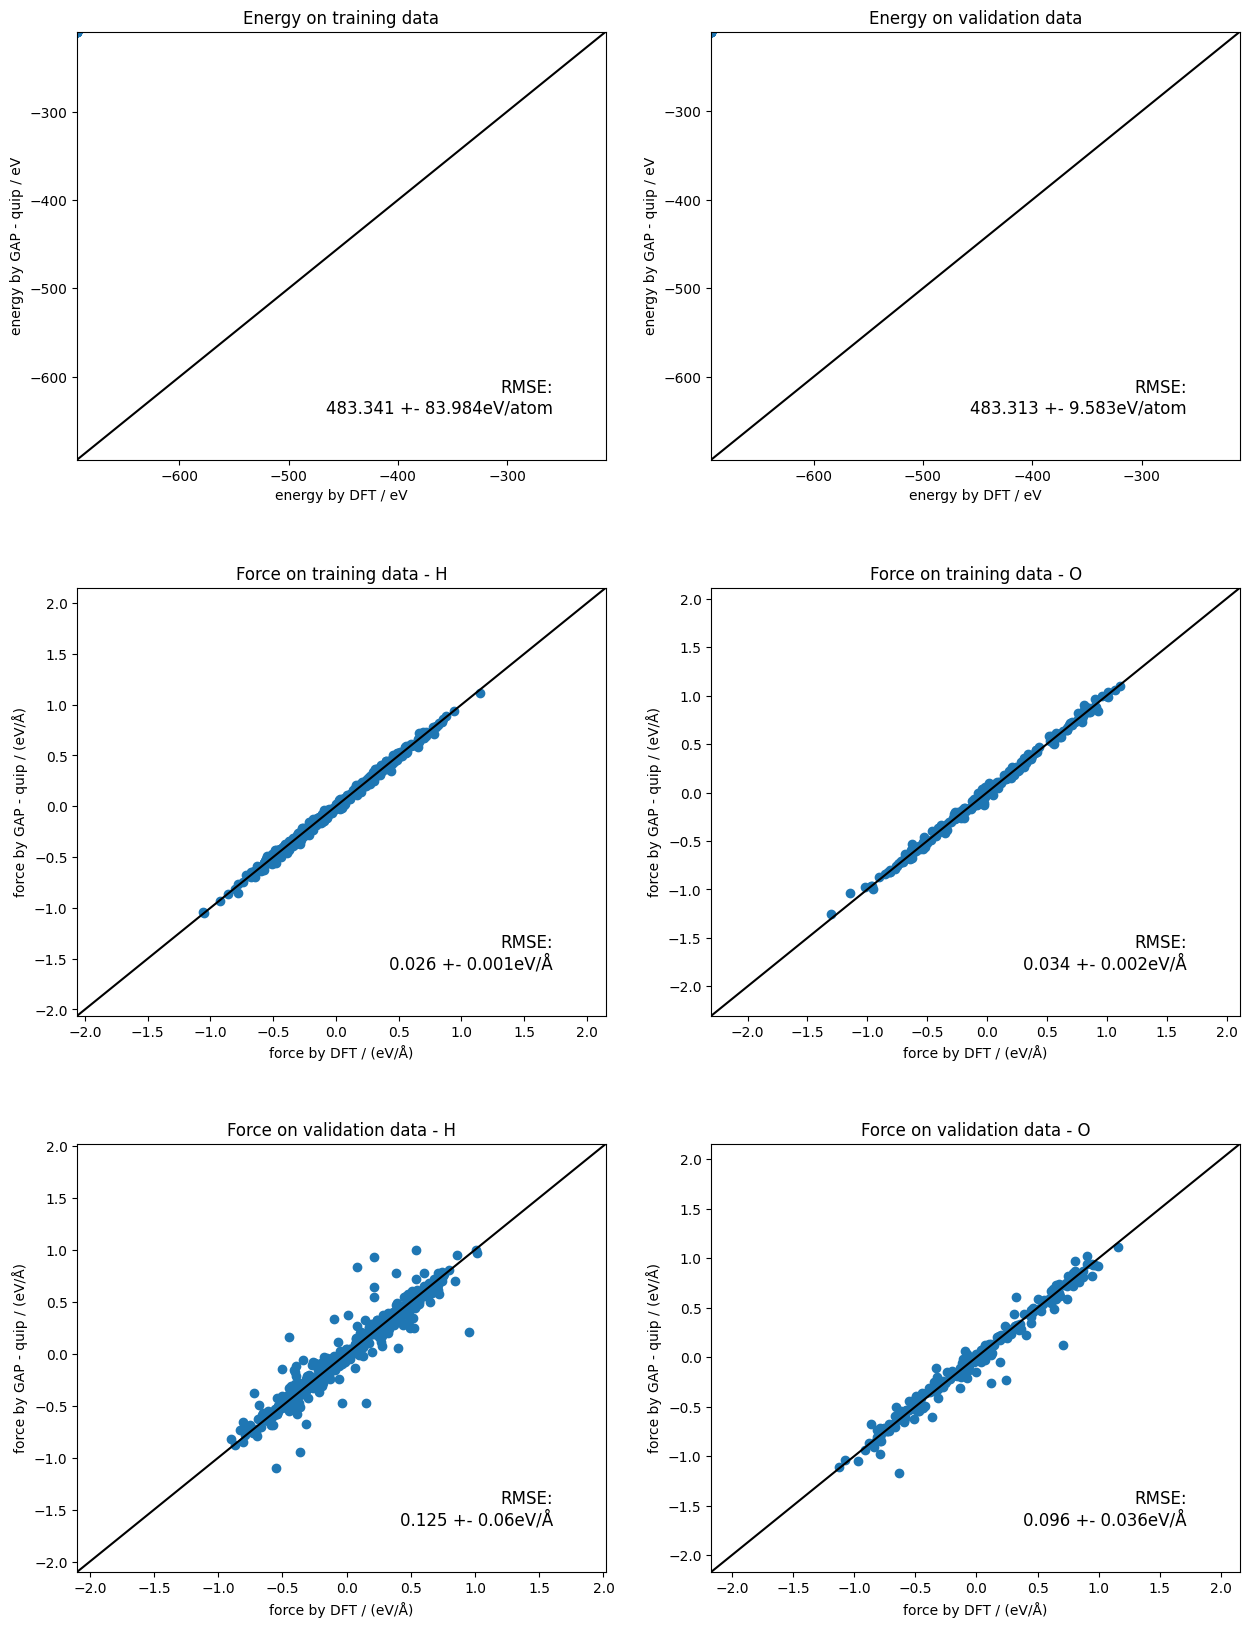

In [12]:
fig, ax_list = plt.subplots(nrows=3, ncols=2, gridspec_kw={'hspace': 0.3})
fig.set_size_inches(15, 20)
ax_list = ax_list.flat[:]

# energy_plot('trainWater.xyz', 'quip_train.xyz', ax_list[0], 'Energy on training data')
energy_plot('trainCalc.xyz', 'quip_train.xyz', ax_list[0], 'Energy on training data')
energy_plot('validate.xyz', 'quip_validate.xyz', ax_list[1], 'Energy on validation data')
# force_plot('trainWater.xyz', 'quip_train.xyz', ax_list[2], 'H', 'Force on training data - H')
# force_plot('trainWater.xyz', 'quip_train.xyz', ax_list[3], 'O', 'Force on training data - O')

force_plot('trainCalc.xyz', 'quip_train.xyz', ax_list[2], 'H', 'Force on training data - H')
force_plot('trainCalc.xyz', 'quip_train.xyz', ax_list[3], 'O', 'Force on training data - O')

force_plot('validate.xyz', 'quip_validate.xyz', ax_list[4], 'H', 'Force on validation data - H')
force_plot('validate.xyz', 'quip_validate.xyz', ax_list[5], 'O',  'Force on validation data - O')

# if you wanted to have the same limits on the force plots
#for ax in ax_list[2:]:
#    flim = (-20, 20)
#    ax.set_xlim(flim)
#    ax.set_ylim(flim)

In [13]:
def energy_plot(in_file, out_file, ax, title='Plot of energy'):
    """ Plots the distribution of energy per atom on the output vs the input"""
    # read files
    in_atoms = ase.io.read(in_file, ':')
    out_atoms = ase.io.read(out_file, ':')
    # list energies
    # ener_in = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in in_atoms]
    # ener_out = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in out_atoms]
    ener_in = [at.info["energy"] / len(at.get_chemical_symbols()) for at in in_atoms]
    ener_out = [at.info["kqeq_energy_whole"] / len(at.get_chemical_symbols()) for at in out_atoms]
    # scatter plot of the data
    ax.scatter(ener_in, ener_out)
    # get the appropriate limits for the plot
    for_limits = np.array(ener_in +ener_out)
    elim = (for_limits.min() - 0.05, for_limits.max() + 0.05)
    ax.set_xlim(elim)
    ax.set_ylim(elim)
    # add line of slope 1 for refrence
    ax.plot(elim, elim, c='k')
    # set labels
    ax.set_ylabel('energy by GAP - python / eV')
    ax.set_xlabel('energy by DFT / eV')
    #set title
    ax.set_title(title)
    # add text about RMSE
    _rms = rms_dict(ener_in, ener_out)
    rmse_text = 'RMSE:\n' + str(np.round(_rms['rmse'], 3)) + ' +- ' + str(np.round(_rms['std'], 3)) + 'eV/atom'
    ax.text(0.9, 0.1, rmse_text, transform=ax.transAxes, fontsize='large', horizontalalignment='right',
            verticalalignment='bottom')

def force_plot(in_file, out_file, ax, symbol='HO', title='Plot of force'):
    """ Plots the distribution of firce components per atom on the output vs the input
        only plots for the given atom type(s)"""

    in_atoms = ase.io.read(in_file, ':')
    out_atoms = ase.io.read(out_file, ':')

    # extract data for only one species
    in_force, out_force = [], []
    for at_in, at_out in zip(in_atoms, out_atoms):
        # get the symbols
        sym_all = at_in.get_chemical_symbols()
        # add force for each atom
        for j, sym in enumerate(sym_all):
            if sym in symbol:
                in_force.append(at_in.arrays['forces'][j])
                #out_force.append(at_out.get_forces()[j]) \
                out_force.append(at_out.arrays['kqeq_forces'][j]) # because QUIP and ASE use different names

    ax.scatter(in_force, out_force)
    # get the appropriate limits for the plot
    for_limits = np.array(in_force + out_force)
    flim = (for_limits.min() - 1, for_limits.max() + 1)
    ax.set_xlim(flim)
    ax.set_ylim(flim)
    # add line of
    ax.plot(flim, flim, c='k')
    # set labels
    ax.set_ylabel('force by GAP - python / (eV/Å)')
    ax.set_xlabel('force by dft / (eV/Å)')
    #set title
    ax.set_title(title)
    # add text about RMSE
    _rms = rms_dict(in_force, out_force)
    rmse_text = 'RMSE:\n' + str(np.round(_rms['rmse'], 3)) + ' +- ' + str(np.round(_rms['std'], 3)) + 'eV/Å'
    ax.text(0.9, 0.1, rmse_text, transform=ax.transAxes, fontsize='large', horizontalalignment='right',
            verticalalignment='bottom')

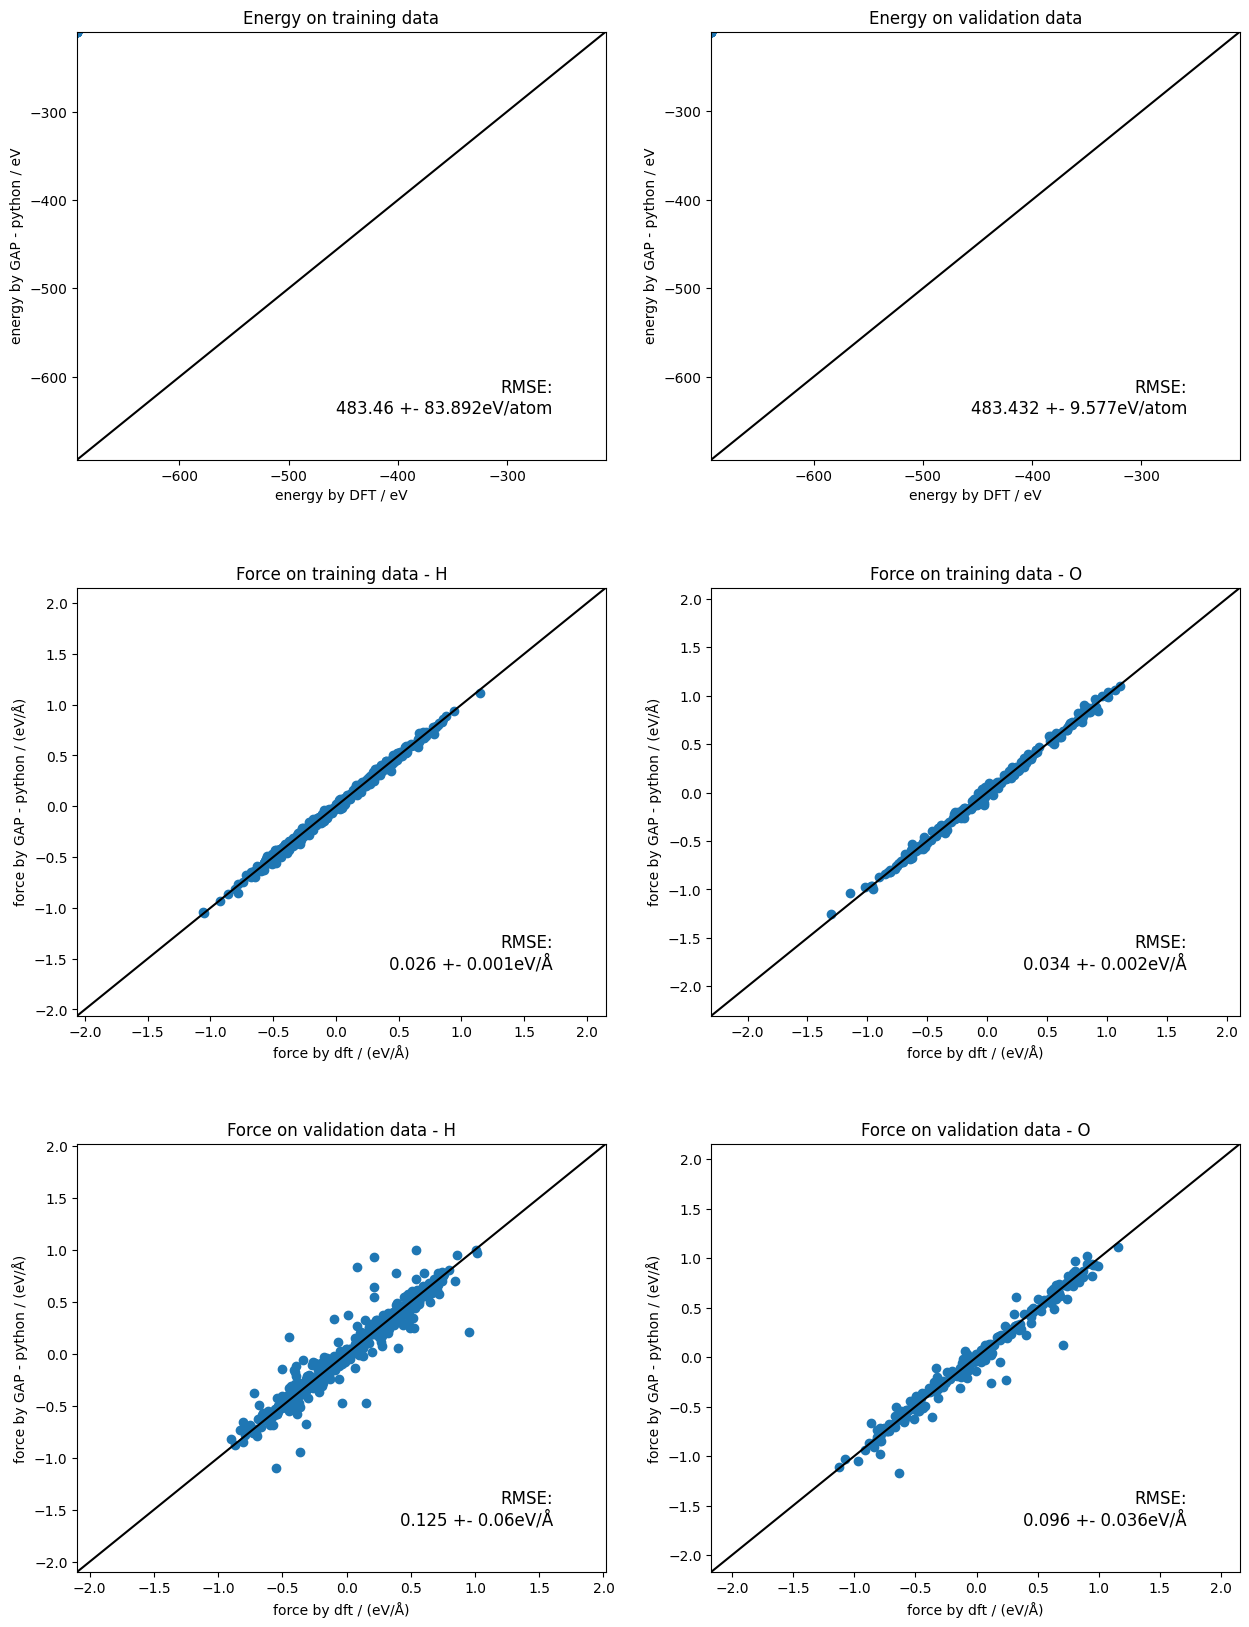

In [14]:
fig, ax_list = plt.subplots(nrows=3, ncols=2, gridspec_kw={'hspace': 0.3})
fig.set_size_inches(15, 20)
ax_list = ax_list.flat[:]
# energy_plot('trainWater.xyz', 'quip_train.xyz', ax_list[0], 'Energy on training data')
energy_plot('trainCalc.xyz', 'kqeq_train.xyz', ax_list[0], 'Energy on training data')
energy_plot('validate.xyz', 'kqeq_test.xyz', ax_list[1], 'Energy on validation data')
# force_plot('trainWater.xyz', 'quip_train.xyz', ax_list[2], 'H', 'Force on training data - H')
# force_plot('trainWater.xyz', 'quip_train.xyz', ax_list[3], 'O', 'Force on training data - O')

force_plot('trainCalc.xyz', 'kqeq_train.xyz', ax_list[2], 'H', 'Force on training data - H')
force_plot('trainCalc.xyz', 'kqeq_train.xyz', ax_list[3], 'O', 'Force on training data - O')

force_plot('validate.xyz', 'kqeq_test.xyz', ax_list[4], 'H', 'Force on validation data - H')
force_plot('validate.xyz', 'kqeq_test.xyz', ax_list[5], 'O',  'Force on validation data - O')


# energy_plot('testWater.xyz', 'kqeq_results.xyz', ax_list[1], 'Energy on validation data')
# force_plot('testWater.xyz', 'kqeq_results.xyz', ax_list[2], 'H', 'Force on training data - H')
# force_plot('testWater.xyz', 'kqeq_results.xyz', ax_list[3], 'O', 'Force on training data - O')

In [15]:
a = np.array([-67796.158509834553],dtype=np.float64)

In [16]:
print(a)

[-67796.15850983]


In [17]:
allKLs = np.load("LK.npy")
ref = np.load("ref.npy")
bigKmm = np.load("bigKmm.npy")
sigma = np.load("sigmas.npy")


In [18]:
f = open("testFile_Kmn.0").readlines()
allKLs_quip = np.array([float(a) for a in f])
f = open("testFile_globalY.0").readlines()
ref_quip = np.array([float(a) for a in f])
f = open("testFile_Kmm").readlines()
bigKmm_quip = np.array([float(a) for a in f])
f = open("testFile_lambda.0").readlines()
sigma_quip = np.array([float(a) for a in f])

In [19]:
s = allKLs.shape
allKLs_quip = allKLs_quip.reshape(s)
s = ref.shape
ref_quip=ref_quip.reshape(s)
s = bigKmm.shape
bigKmm_quip = bigKmm_quip.reshape(s)
s = sigma.shape
sigma_quip =np.diag(sigma_quip)#.reshape(s)


ValueError: cannot reshape array of size 142128 into shape (271,90)

In [ ]:
f = open("w_temp").readlines()
weights_quip = np.array([float(a) for a in f])
f = open("GAP.xml.sparseX.GAP_2024_2_29_0_13_36_40_2521").readlines()
soap_O_quip = np.array([float(a) for a in f])
f = open("GAP.xml.sparseX.GAP_2024_2_29_0_13_36_40_2522").readlines()
soap_H_quip= np.array([float(a) for a in f])

In [ ]:
soaps = np.concatenate((soap_O_quip.reshape(500,145),soap_H_quip.reshape(500,145)))
elO = np.array(["O" for _ in range(500)])
elH = np.array(["H" for _ in range(500)])
el = np.concatenate((elO,elH))
# np.save("KQE")


In [ ]:
np.save("KQEqEl_0.npy",el)
np.save("KQEqSOAP_0.npy",soaps.reshape(1000,145))
np.save("KQEqWeights.npy",weights_quip)


In [ ]:
np.save(allKLs_quip)
np.save(ref_quip)
np.save(bigKmm_quip)
np.save(sigma_quip)

TypeError: save() missing 1 required positional argument: 'arr'

In [ ]:
np.save("KQEqSOAP.npy",bigKmm_quip.reshape((1000,1000)))
els = []
els.extend(["O" for a in range(500)])
els.extend(["H" for a in range(500)])

ValueError: cannot reshape array of size 324 into shape (1000,1000)

In [ ]:
print(els)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

In [ ]:
print(bigKmm.shape)
print(bigKmm)
print(bigKmm_quip.reshape(18,18))

(18, 18)
[[1.         0.93505667 0.99834194 0.99776913 0.99938856 0.99924967
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.93505667 1.         0.93962145 0.93891291 0.93748151 0.93799372
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.99834194 0.93962145 1.         0.99859555 0.99972876 0.9995017
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.99776913 0.93891291 0.99859555 1.         0.99873456 0.99917265
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.99938856 0.93748151 0.99972876 0.99873456 1.         0.99983748
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.999

In [ ]:
print(sigma.sum(axis=1)/sigma_quip)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [ ]:
f = open("GAP.xml.sparseX.GAP_2024_2_28_0_9_5_22_3081").readlines()
soap_O_quip = np.array([float(a) for a in f])

In [ ]:
f = open("GAP.xml.sparseX.GAP_2024_2_28_0_9_5_22_3082").readlines()
soap_H_quip = np.array([float(a) for a in f])

In [ ]:
print(soap_H_quip.shape)
print(soap_O_quip.shape)

(20880,)
(10440,)


In [ ]:
72500/500


145.0

In [ ]:
soap_H_quip = (soap_H_quip.reshape((144,145)))
soap_O_quip = (soap_O_quip.reshape((72, 145)))

In [ ]:
all_soap_quip = np.concatenate((soap_O_quip,soap_H_quip))
print(all_soap_quip.shape)
np.save("quip_soap.npy",all_soap_quip)

(216, 145)


In [ ]:
reprSOAP_kqeq = np.load("reprSOAP.npy")
reprEl_kqeq = np.load("reprEl.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'reprEl.npy'

In [ ]:
print(reprSOAP_kqeq.shape)
print(reprEl_kqeq.shape)

(1, 216, 145)
(1, 216)


In [ ]:
print(reprEl_kqeq)

[['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
  'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
  'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
  'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
  'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
  'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
  'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
  'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
  'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
  'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
  'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
  'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H']]


In [ ]:
wh = np.where(reprEl_kqeq =='O',True,False)
wh = (wh.squeeze())
print(wh.shape)
reprSOAP_kqeq = reprSOAP_kqeq.squeeze()
print(reprSOAP_kqeq.shape)

(216,)
(216, 145)


In [ ]:
print(wh)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [ ]:
soap_O_kqeq = reprSOAP_kqeq.squeeze()[wh]

In [ ]:
print(soap_O_quip)

[[ 2.11169439e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.26674365e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.56785111e-01  3.85209518e-03  3.45324789e-03  1.49905292e-03
   2.33969

In [ ]:
for a in range(len(soap_O_kqeq)):
    print("EEEEEEEEEEEEEEEEEEEEEEEEEEEE")
    print(soap_O_kqeq[a]/soap_O_quip[0])
    print("AAAAAAAAAAAAAAAAAAAAAAAAAA")

EEEEEEEEEEEEEEEEEEEEEEEEEEEE
[0.69746973        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.82447932        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.97461742 2.14059943 0.56308793 0.82811767
 1.0586351         nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 1.25141308 2.14394702
 0.56431765 0.82941995 1.60681995 2.14724857 0.56555263 0.83072675
 1.0195417         nan        nan

/tmp/ipykernel_371470/3915904162.py:3: RuntimeWarning: invalid value encountered in divide
  print(soap_O_kqeq[a]/soap_O_quip[0])


In [ ]:
repr_kqeq = np.load("repres_descs.npy",allow_pickle=True)

In [ ]:
repr_O = repr_kqeq[0]["O"]

In [ ]:
print(repr_O[2])

[ 2.11343555e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.26241253e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.55165132e-01  7.42322145e-03  1.93518742e-03  1.55075188e-03
  2.34681982e-01  0.00000

In [ ]:
sigma = np.load("SigmaEF.npy")
print(sigma)

[[  5.55555556   0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.         100.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.  

In [ ]:
[  5.55555556   0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0.        ]
 [  0.         100.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.        ]
 [  0.           0.         100.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.         100.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.         100. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.100.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.  0.         100.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.  0.           0.         100.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0. 0.           0.           0.         100.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0. 0.           0.           0.           0.         100. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.   0.           0.           0.           0.           0. 100.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.   0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.         100.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0. 0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.         100.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.         100.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.         100.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
  100.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.         100.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.         100.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.         100.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.         100.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
  100.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.         100.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.         100.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.         100.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.         100.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
  100.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.         100.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.         100.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.         100.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.         100.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
  100.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.         100.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.         100.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.         100.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.         100.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
  100.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.         100.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.         100.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.         100.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.         100.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
  100.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.         100.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.         100.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.         100.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.         100.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
  100.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.         100.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.         100.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.         100.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.         100.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
  100.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.         100.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.         100.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.         100.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.         100.        ]]
